In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from tqdm.auto import tqdm
from scipy.stats import linregress
import pandas as pd

import pathlib
import sys


from scipy.stats import kstest, norm
from scipy.stats import linregress
import statsmodels.api as sm
from scipy.optimize import minimize

path = pathlib.Path().resolve().parent
sys.path.insert(0, str(path))

from src.mixture_fit import fits, fit, sum_exp, loss_function, right_order, error_estimate
from src.data_loading import load_data
from src.bootstrapping import bootstrap

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 


%matplotlib widget

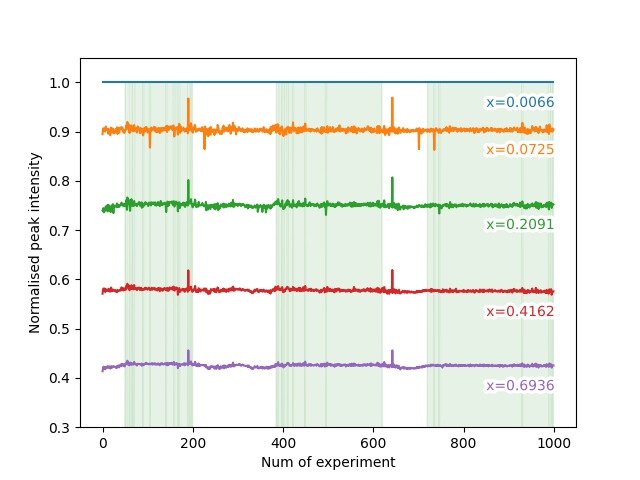

(631, 5)


In [13]:
x, y = np.loadtxt(path.joinpath('data', '1000experiments.txt'), skiprows=1, usecols=[1, 2]).T

x = x.reshape(-1, 5)
y = y.reshape(-1, 5)

y = y / y.max(1).reshape(-1, 1)
x = x / 1e6

prev_sum = 0
mask = np.ones(len(y), dtype=bool)

mask[:50] = False
mask[200:385] = False
mask[620:720] = False

base_mask = mask.copy()
for i in range(1, 5):
    # print(i)
    prev_sum = 0
    while prev_sum != mask.sum():
        # print(i, prev_sum, mask.sum())
        prev_sum = mask.sum()
        mean, sigma = y[mask].T[i].mean(), y[mask].T[i].std()
        mask = base_mask * (y.T[i] > (mean - 3*sigma)) * (y.T[i] < (mean + 3*sigma))
    base_mask = mask.copy()

x = x[mask]
y_print = y.copy()
y = y[mask]

plt.close()

# for i in range(5):
    # plt.plot(y_print.T[i][40:-10])
    # plt.plot(butter_lowpass_filter(y_print.T[i], 0.5, 10)[50:])
# plt.yscale('log')
x_values = np.where(mask)[0]
for i in range(5):
    sl, inter ,_ ,_ ,_  = linregress(x_values, y.T[i])
    p = plt.plot(y_print.T[i])
    # plt.plot(sl*np.arange(0, 1000) + inter)
    plt.annotate(f'x={x[0, i]:.4f}', [850, y_print.T[i][-1]-0.05], color=p[0].get_color(), path_effects=[pe.withStroke(linewidth=5, foreground="white")])
plt.fill_between(np.arange(0, len(y_print)), 0, y.max()*mask, color='green', alpha=0.1)

idx = 4
# plt.hlines([y.T[idx][:100].mean(), y.T[idx][150:300].mean(), y.T[idx][400:].mean()], 0, 1000, colors='red', alpha=0.4)
# plt.hlines(y.T[idx][:100].mean(), 50, 200, colors='red', edgecolors='black')
# plt.hlines(y.T[idx][150:300].mean(), 400, 600, colors='red', edgecolors='black')
# plt.hlines(y.T[idx][400:].mean(), 730, 1000, colors='red', edgecolors='black')
plt.ylabel('Normalised peak intensity')
plt.xlabel('Num of experiment')
plt.ylim(bottom=0.3)
plt.show()
# plt.savefig('figures/1000stats/1000_plot.png', dpi=300)

print(y.shape)

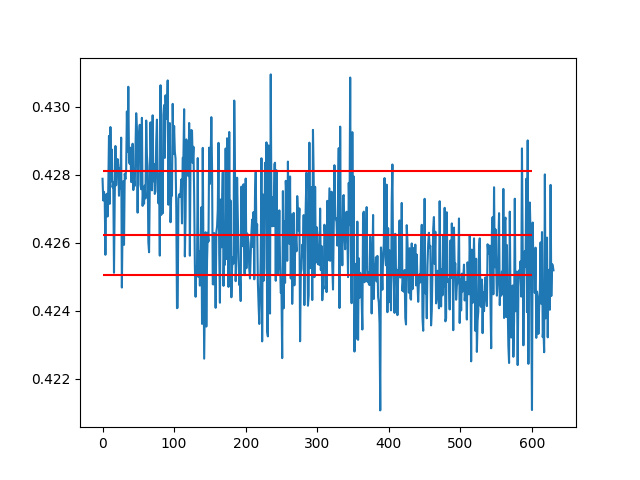

In [14]:
plt.close()
plt.plot(y.T[-1])
plt.hlines([y.T[-1][:100].mean(), y.T[-1][150:300].mean(), y.T[-1][400:].mean()], 0, 600, colors='red')
plt.show()

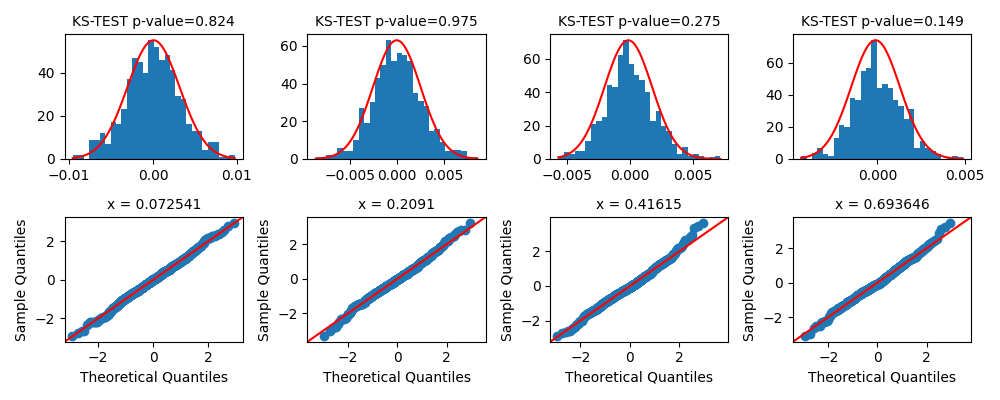

In [15]:
plt.close()
plt.figure(figsize=(10,4))
dist_type = norm
num_of_plots = 4
for i in range(1, 5):
    x_values = np.where(mask)[0]
    sl, inter ,_ ,_ ,_  = linregress(x_values, y.T[i])
    plt.subplot(2, num_of_plots, i)
    # y_data = y.T[i][90:-20] - butter_lowpass_filter(y.T[i], 0.3, 10)[110:]
    y_data = y.T[i] - (x_values * sl + inter)
    q16, q50, q84 = np.quantile(y_data, [0.159, 0.50, 0.841])
    _mean, _std = q50, (q84-q16)/2
    _hist_data, _bins, _ = plt.hist(y_data, bins=30, histtype='stepfilled')
    x_space = np.linspace(_bins[0], _bins[-1], 100)
    norm_dist = dist_type.pdf(x_space, *[_mean, _std])
    norm_dist = norm_dist/norm_dist.max() * _hist_data.max()
    plt.plot(x_space, norm_dist, c='red')
    ks_statistic, p_value = kstest(y_data, dist_type.cdf, args=(_mean, _std))
    plt.title(f'KS-TEST p-value={p_value:.3f}', fontsize=10)

    plt.subplot(2, num_of_plots, num_of_plots + i)
    _ = sm.qqplot(y_data, dist=dist_type, fit=True, line="45", ax=plt.gca())
    # plt.ylim(-3, 3)
    # plt.xlim(-3, 3)
    plt.title(f'x = {x[0][i]}', fontsize=10)
plt.tight_layout()
plt.show()

In [20]:
folder = path.joinpath('data', 'R2_5times')
x_arr = []
y_arr_norm = []
y_arr = []
for i in range(1, 6):
    data_path = pathlib.Path(folder, f'DOSY-R2-1-4-DMSO-128points-{i}.txt')
    x1, y1 = load_data(data_path)
    x2, y2 = np.loadtxt(data_path, skiprows=2, usecols=(1,2)).T
    x_arr.append(x1)
    y_arr_norm.append(y1)
    y_arr.append(y2)

y_arr_norm = np.vstack(y_arr_norm)
y_arr = np.vstack(y_arr)

In [27]:
cov_matrix = np.cov(y_arr.T)
var1 = cov_matrix[0,0] / y_arr.mean(0)[0] ** 2
var2 = np.diag(cov_matrix)[1:] / y_arr.mean(0)[1:] ** 2
covar = cov_matrix[0, 1:]/(y_arr.mean(0)[0] * y_arr.mean(0)[1:])

theor_std = (var1 + var2 - 2 * covar) ** 0.5

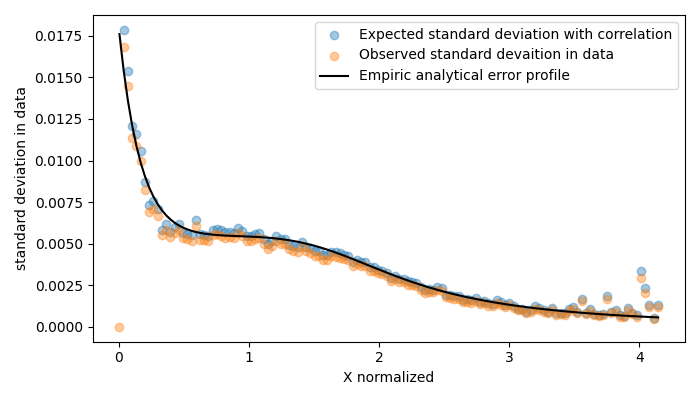

In [40]:
plt.close()
plt.figure(figsize=(7,4))
plt.scatter(x_arr[1][1:], theor_std * y_arr_norm.mean(0)[1:], alpha=0.4, label='Expected standard deviation with correlation')
plt.scatter(x_arr[1], y_arr_norm.std(0), alpha=0.4, label='Observed standard devaition in data')
plt.plot(x_arr[1], error_estimate(x_arr[1]), label='Empiric analytical error profile', color='black')
plt.ylabel('standard deviation in data')
plt.xlabel('Z normalized')
plt.tight_layout()
plt.legend()
plt.show()